In [10]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader
from syndatagenerators.data_preparation.lsm_data import LSMDataset
from syndatagenerators.models.embedding.mlp import BasicMLP
from syndatagenerators.models.embedding.mlp import BayesianMtlEmbeddingLearner
from syndatagenerators.models.embedding.gan import BayesianMtlEmbeddingGAN
from syndatagenerators.models.embedding.utils import plot_test_samples, filter_by_task_id

In [11]:
# general setup

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

cat_columns = ['LCLid']
cont_columns = ['Summer_Time', 'Year_Sin', 'Year_Cos', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos']
target_columns = ['KWH_per_half_hour']

file_ids = np.arange(10)
n_files = len(file_ids)
embedding_dim = 2
batch_size = 512
n_epochs = 100
kl_weight = 0.001

In [12]:
# init and load dataset

dataset = LSMDataset(
    store_path='../../data/londonSmartMeter.h5', 
    file_ids=file_ids ,
    cat_columns=cat_columns,
    cont_columns=cont_columns,
    target_columns=target_columns,
    seq_len=4*48)

train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])

dl_train = DataLoader(
    dataset=dataset_train, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True)

dl_test = DataLoader(
    dataset=dataset_test, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=True)

print(len(dataset), len(dataset_train), len(dataset_test))

100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


1263 1010 253


torch.Size([512, 192, 1]) torch.Size([512, 192, 7]) torch.Size([512, 192, 1])


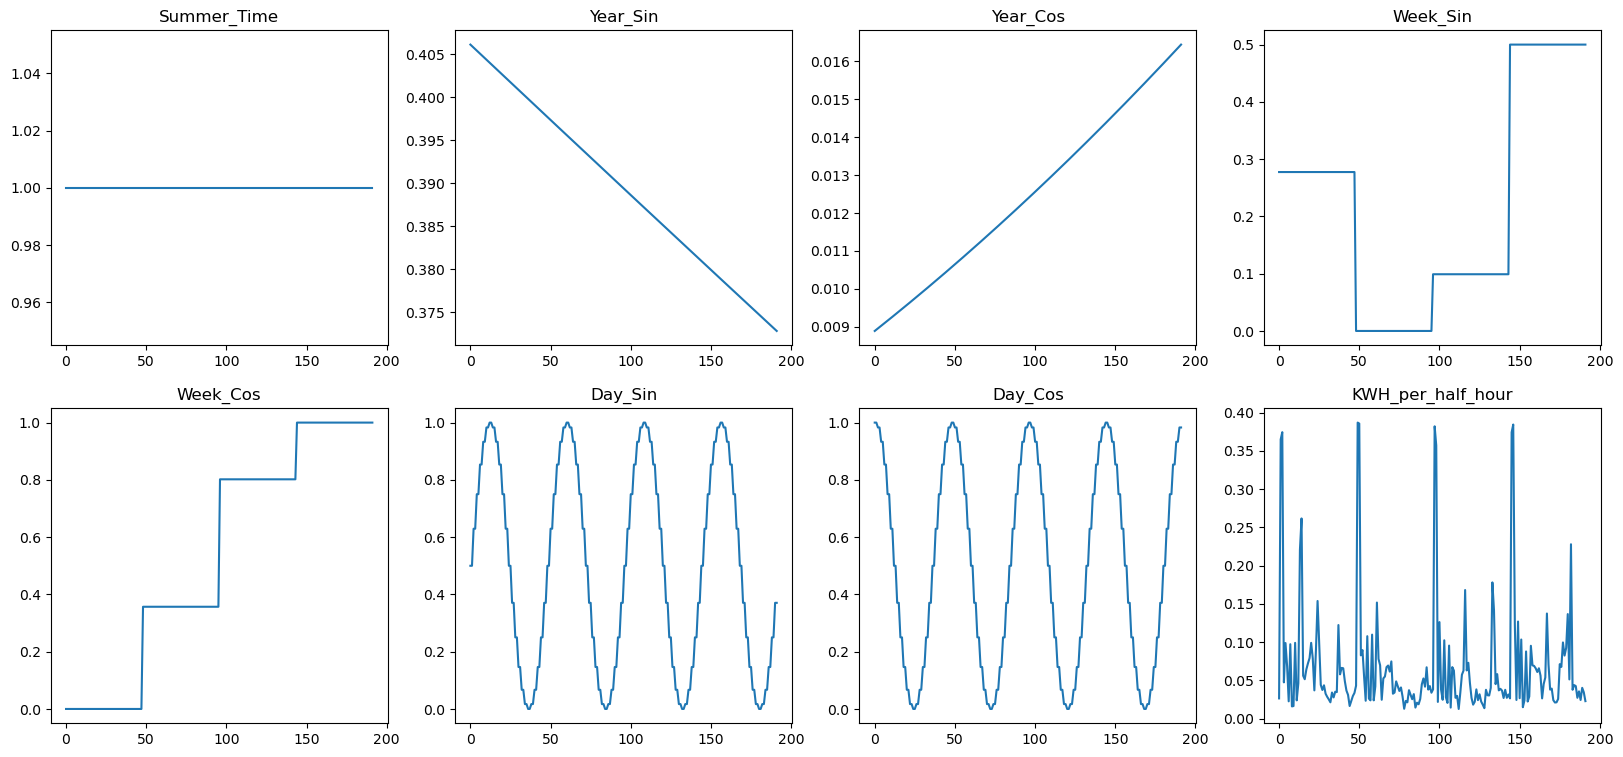

In [13]:
# show examplary data

n_samples = 1 #number of samples to plot
c = 0
for x_cat, x_cont, y in dl_train:
    print(x_cat.shape, x_cont.shape, y.shape)
    c += 1
    if c>n_samples:
        break

    plt.figure(figsize=(20, 9))
    for plt_id in range(len(cont_columns)):
        plt.subplot(2, 4, plt_id+1)
        plt.plot(x_cont[0, :, plt_id])
        plt.title(cont_columns[plt_id])
    plt.subplot(2, 4, 8)
    plt.title(target_columns[0])
    plt.plot(y[0, :, 0])
    plt.savefig('figures/data_samples.png')
    plt.show()

In [14]:
# load model and prepare training

model = BasicMLP(n_features=len(cont_columns), n_hidden=256, n_targets=1)
learner = BayesianMtlEmbeddingLearner(model=model, n_tasks=n_files)
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-3)
optimizer = torch.optim.RMSprop(learner.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)

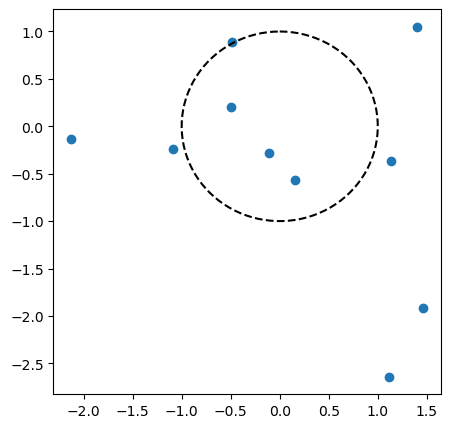

In [15]:
# show embedding space before training

plt.figure(figsize=(5, 5))
learner.plot_bayes_embedding_space(show_circles=False)
plt.savefig('figures/embedding_untrained.png')
plt.show()

In [16]:
# training loop

learner.train(dl_train=dl_train, optimizer=optimizer, criterion=criterion, n_epochs=n_epochs)

100%|██████████| 100/100 [00:01<00:00, 51.35it/s]


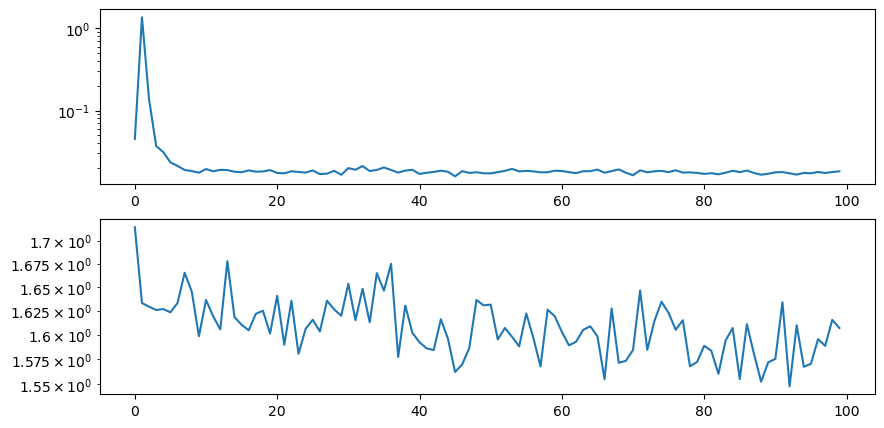

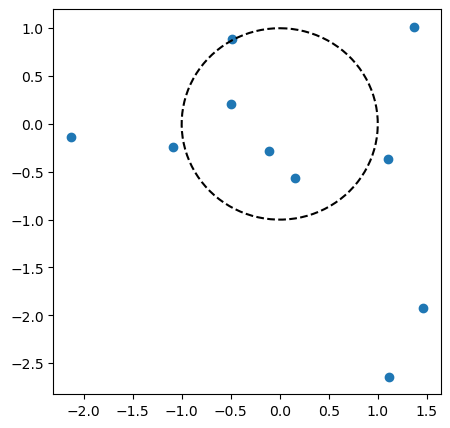

In [17]:
# plot training progress & embedding space of the trained model

learner = learner.to('cpu')
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.semilogy(learner.criterion_history)
plt.subplot(2, 1, 2)
plt.semilogy(learner.kl_history)
plt.savefig('figures/embedding_loss.png')
plt.show()

plt.figure(figsize=(5, 5))
learner.plot_bayes_embedding_space(show_circles=False)
plt.savefig('figures/embedding.png')
plt.show()

In [18]:
# plot real and generated samples for different tasks

test_samples = learner.get_test_samples(dl_test)

plt.figure(figsize=(20, 10))
plot_test_samples(test_samples=test_samples)
plt.legend()
plt.savefig('figures/mlp_real_vs_generated.png')
plt.show()

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# plot generated samples for specific tasks

for task_id in file_ids[:1]:
    filtered_samples = filter_by_task_id(test_samples=test_samples, task_id=task_id)
    plt.figure(figsize=(20, 10))
    plot_test_samples(test_samples=filtered_samples)
    plt.legend()
    plt.savefig(f'figures/mlp_generated_{task_id}')
    plt.show()

In [ ]:
# init gan model with pre-trained embeddings

gan = BayesianMtlEmbeddingGAN(feature_dim=len(cont_columns), n_tasks=n_files)
gan.mu_embed.weight = learner.mu_embed.weight
gan.log_var_embed.weight = learner.log_var_embed.weight

gan_optimizer = {
    'gen_opt': torch.optim.RMSprop(params=gan.gen_net.parameters(), lr=1e-4),
    'dis_opt': torch.optim.RMSprop(params=gan.dis_net.parameters(), lr=1e-4)
}
criterion = torch.nn.BCELoss()

# train the gan model on the respective data
gan.train(dl_train=dl_train, optimizer=gan_optimizer, criterion=criterion, n_epochs=n_epochs)

plt.figure(figsize=(10, 5))
plt.plot(gan.gen_history, label='gen')
plt.plot(gan.dis_history, label='dis')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 30))
p_id = 1
for t_id in np.arange(0, 30):
    plt.subplot(6, 5, p_id)

    y_real = torch.cat([y[x_cat[:, 0, 0]==t_id] for x_cat, _, y in dl_train])
    high_real = (y_real.mean(dim=0)+y_real.std(dim=0)).flatten()
    low_real = (y_real.mean(dim=0)-y_real.std(dim=0)).flatten()
    plt.fill_between(np.arange(48), high_real, low_real, alpha=0.5)

    x_cont = torch.cat([x_cont[x_cat[:, 0, 0]==t_id] for x_cat, x_cont, _ in dl_train])
    gen_input = torch.ones(x_cont.shape[0], 48, 1)
    y_fake = gan.generator(gen_input*t_id, x_cont).detach()
    high_fake = (y_fake.mean(dim=0)+y_fake.std(dim=0)).flatten()
    low_fake = (y_fake.mean(dim=0)-y_fake.std(dim=0)).flatten()
    plt.fill_between(np.arange(48), high_fake, low_fake, alpha=0.5)

    plt.plot(y_real.mean(dim=0), label='real')
    plt.plot(y_fake.mean(dim=0), label='fake')

    plt.ylim(-0.25, 0.75)
    plt.title(t_id)

    if p_id==1:
        plt.legend()

    p_id += 1

plt.savefig('figures/gan_distributions_30.png')
plt.show()